In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch.nn as nn
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        # self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 128)
        self.fc3 = nn.Linear(128, 64)
        # self.fc4 = nn.Linear(64,2)
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # # Non-linearity  # NON-LINEAR
        # out = self.sigmoid(out)
        # # Linear function (readout)  # LINEAR
        # out = self.fc2(out)

        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        # out = self.sigmoid(out)

        return out

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00


In [14]:
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import json
from matplotlib import pyplot as plt
import statistics
from datasets import Dataset

labels = []
with open("/content/gdrive/MyDrive/honest_llama/responses/llama_7B_nq_open_greedy_responses_labels_1800.json", 'r') as read_file:
    for line in read_file:
        data = json.loads(line)
        labels.append(1 if data['rouge1_to_target']>0.3 else 0)
# labels = labels[:540]
np.sum(labels)

318

In [ ]:
num_layers = 32
num_heads = 32
ah_dims = 128

token_idxes = np.load(f"/content/gdrive/MyDrive/honest_llama/responses/llama_7B_nq_open_greedy_responses_1800_response_start_token_idx.npy")

file_ends = [(a*20)+20 for a in range(int(540/20))] + [(a*10)+10 for a in range(int(860/10)) if (a*10)+10>540] + [(a*5)+5 for a in range(int(1800/5)) if (a*5)+5>860]
ah_wise_activations = []
for file_end in file_ends:
    acts = np.load(f"/content/gdrive/MyDrive/honest_llama/features/llama_7B_nq_open_all/llama_7B_nq_open_all_head_wise_{file_end}.pkl",allow_pickle=True)
    ah_wise_activations.append(np.stack([act[:,-1,:] for act in acts], axis=0)) # only last token
    # ah_wise_activations.append(np.stack([act[:,0,:] for act in acts], axis=0)) # only first token
    # ah_wise_activations.append(np.stack([act[:,token_idxes[file_end-20+i]-1,:] for i,act in enumerate(acts)], axis=0)) # last token of prompt
    # ah_wise_activations.append(np.stack([np.mean(act,axis=1) for act in acts], axis=0)) # avg across all tokens
    # ah_wise_activations.append(np.stack([np.max(act,axis=1) for act in acts], axis=0)) # max across all tokens
ah_wise_activations = np.concatenate(ah_wise_activations, axis=0)
assert ah_wise_activations.shape[1:] == (32, 4096)
assert len(labels)==len(ah_wise_activations)
ah_wise_activations = np.reshape(ah_wise_activations,(ah_wise_activations.shape[0],num_layers,num_heads,ah_dims))

In [ ]:
import numpy as np
np.random.seed(42)
using_act = 'ah'
non_linear = True
using_chosen_dims = False

# Individual probes
len_dataset = len(mlp_wise_activations) if using_act == 'mlp' else len(ah_wise_activations)

all_val_accs = {}
all_val_f1s = {}
all_test_accs = {}
all_test_f1s = {}
all_test_preds = {}
y_true_test = {}
fold_idxs = np.array_split(np.arange(len_dataset), 2)
for i in range(2):
    train_idxs = np.concatenate([fold_idxs[j] for j in range(2) if j != i])
    test_idxs = fold_idxs[i]
    train_set_idxs = np.random.choice(train_idxs, size=int(len(train_idxs)*(1-0.2)), replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    tot = len(test_idxs)
    print('baseline accuracy:',max(sum([labels[i] for i in test_idxs])
                                  ,tot-sum([labels[i] for i in test_idxs])
                                  )/tot)

    if using_act == 'mlp':
        all_X_train = np.stack([mlp_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([mlp_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([mlp_wise_activations[i] for i in test_idxs], axis = 0)
    else:
        all_X_train = np.stack([ah_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([ah_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([ah_wise_activations[i] for i in test_idxs], axis = 0)
    y_train = np.stack([labels[i] for i in train_set_idxs], axis = 0)
    y_val = np.stack([labels[i] for i in val_set_idxs], axis = 0)
    y_test = np.stack([labels[i] for i in test_idxs], axis = 0)
    y_true_test[i] = y_test
    if non_linear:
        # y_train = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_train], dtype='float32')
        # y_val = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_val], dtype='float32')
        # y_test = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_test], dtype='float32')
        y_train = np.vstack([[val] for val in y_train], dtype='float32')
        y_val = np.vstack([[val] for val in y_val], dtype='float32')
        y_test = np.vstack([[val] for val in y_test], dtype='float32')

    all_val_accs[i] = []
    all_val_f1s[i] = []
    all_test_accs[i] = []
    all_test_f1s[i] = []
    all_test_preds[i] = []
    loop_layers = list(chosen_dims.keys()) if using_chosen_dims else range(num_layers)
    for layer in tqdm(loop_layers):
      loop_heads = range(num_heads) if using_act == 'ah' else [0]
      for head in loop_heads:
        if using_act == 'mlp':
            X_train = np.squeeze(np.take(np.squeeze(all_X_train[:,layer,:]), chosen_dims[layer], axis=1)) if using_chosen_dims else all_X_train[:,layer,:]
            X_val = np.squeeze(np.take(np.squeeze(all_X_val[:,layer,:]), chosen_dims[layer], axis=1)) if using_chosen_dims else all_X_val[:,layer,:]
            X_test = np.squeeze(np.take(np.squeeze(all_X_test[:,layer,:]), chosen_dims[layer], axis=1)) if using_chosen_dims else all_X_test[:,layer,:]
        else:
            X_train = all_X_train[:,layer,head,:]
            X_val = all_X_val[:,layer,head,:]
            X_test = all_X_test[:,layer,head,:]

        if not non_linear:
            wgt_0 = np.sum(y_train)/len(y_train) # class 0 should get low wgt since number of 1s is very low
            clf = LogisticRegression(random_state=42, max_iter=1000, class_weight={0:wgt_0,1:1-wgt_0}).fit(X_train, y_train)
            y_val_pred = clf.predict(X_val)
            all_val_accs[i].append(accuracy_score(y_val, y_val_pred))
            all_val_f1s[i].append(f1_score(y_val, y_val_pred))
            y_test_pred = clf.predict(X_test)
            all_test_accs[i].append(accuracy_score(y_test, y_test_pred))
            all_test_f1s[i].append(f1_score(y_test, y_test_pred))
            all_test_preds[i].append(clf.predict_proba(X_test))
        else:
            ds_train = Dataset.from_dict({"inputs": X_train, "labels": y_train}).with_format("torch")
            ds_train = DataLoader(ds_train, batch_size=4)
            ds_val = Dataset.from_dict({"inputs": X_val, "labels": y_val}).with_format("torch")
            ds_val = DataLoader(ds_val, batch_size=4)
            ds_test = Dataset.from_dict({"inputs": X_test, "labels": y_test}).with_format("torch")
            ds_test = DataLoader(ds_test, batch_size=4)

            input_dim = mlp_dims if using_act=='mlp' else ah_dims # len(chosen_dims[layer]) # 4096
            hidden_dim = 256
            output_dim = 1

            model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
            criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(np.sum(y_train)/(len(y_train)-np.sum(y_train)))) # nn.BCELoss() # nn.CrossEntropyLoss()
            lr = 0.05
            iter_bar = tqdm(ds_train, desc='Train Iter (loss=X.XXX)')

            for epoch in range(10):
              model.train()
              optimizer = torch.optim.SGD(model.parameters(), lr=lr)
              for step,batch in enumerate(iter_bar):
                  optimizer.zero_grad()
                  outputs = model(batch['inputs'])
                  loss = criterion(outputs, batch['labels'])
                  iter_bar.set_description('Train Iter (loss=%5.3f)' % loss.item())
                  loss.backward()
                  optimizer.step()
              lr = lr*0.9
            pred_correct = 0
            y_val_pred = []
            with torch.no_grad():
              model.eval()
              for step,batch in enumerate(ds_val):
                  outputs = model(batch['inputs'])
                  predicted = [1 if pred[0]>0.5 else 0 for pred in nn.Sigmoid()(outputs.data).tolist()]
                  actual = np.squeeze(batch['labels']).tolist()
                  pred_correct += sum([1 if p==a else 0 for p,a in zip(predicted, actual)])
                  y_val_pred += predicted
            # print('Validation Acc:',pred_correct/len(X_val))
            all_val_accs[i].append(pred_correct/len(X_val))
            all_val_f1s[i].append(f1_score([labels[i] for i in val_set_idxs],y_val_pred))
            pred_correct = 0
            y_test_pred = []
            with torch.no_grad():
              model.eval()
              for step,batch in enumerate(ds_test):
                  outputs = model(batch['inputs'])
                  predicted = [1 if pred[0]>0.5 else 0 for pred in nn.Sigmoid()(outputs.data).tolist()]
                  actual = np.squeeze(batch['labels']).tolist()
                  pred_correct += sum([1 if p==a else 0 for p,a in zip(predicted, actual)])
                  y_test_pred += predicted
            # print('Validation Acc:',pred_correct/len(X_test))
            all_test_accs[i].append(pred_correct/len(X_test))
            all_test_f1s[i].append(f1_score([labels[i] for i in test_idxs],y_test_pred))

baseline accuracy: 0.8133333333333334


  0%|          | 0/32 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

Train Iter (loss=X.XXX):   0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
for fold in range(2):
    print('Avg:',np.mean(all_test_accs[fold]),np.mean(all_test_f1s[fold]))
    best, best_f1 = np.argmax(all_val_accs[fold]), np.argmax(all_val_f1s[fold])
    print('Best:',all_test_accs[fold][best],'Layer:',best, all_test_f1s[fold][best_f1],'Layer:',best_f1)

0.6422222222222222 Layer: 13 0.48562300319488816
0.6222222222222222 Layer: 13 0.431438127090301


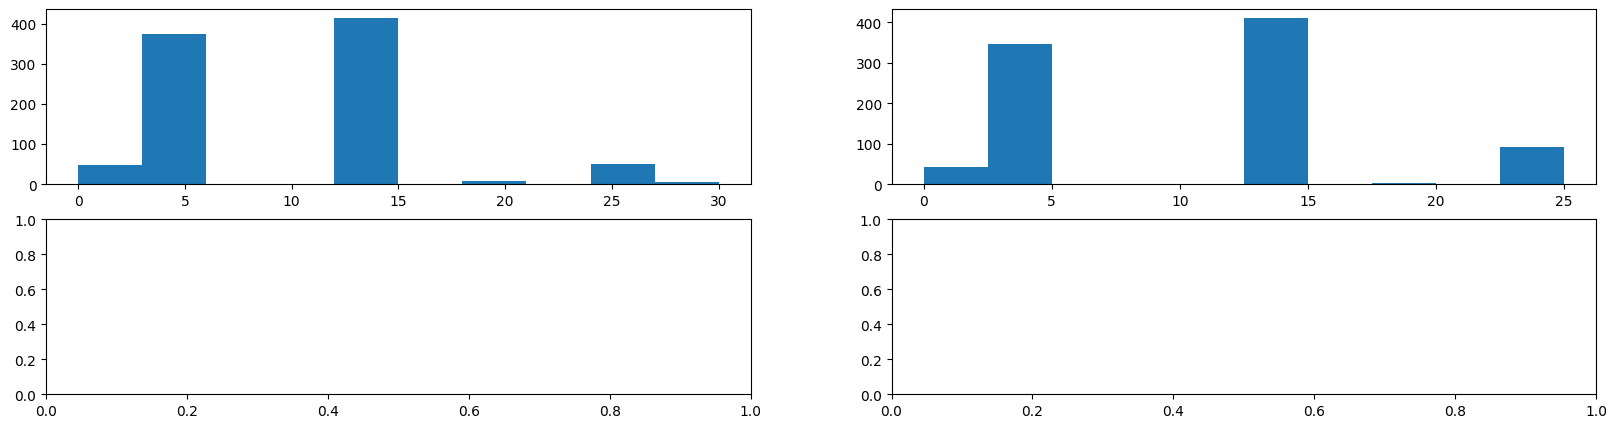

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))
confident_probe, confident_sample_pred = {}, {}
for fold in [0,1]:
    confident_probe[fold], confident_sample_pred[fold] = [], []
    test_preds = np.stack(all_test_preds[fold])
    for i in range(test_preds.shape[1]):
        sample_pred = np.squeeze(test_preds[:,i,:])
        probe_wise_entropy = (-sample_pred*np.log2(sample_pred)).sum(axis=1)[:31]
        confident_probe[fold].append(np.argmin(probe_wise_entropy))
        confident_sample_pred[fold].append(np.argmax(sample_pred[np.argmin(probe_wise_entropy)]))
    print(np.sum(y_true_test[fold]==confident_sample_pred[fold])/len(y_true_test[fold]), 'Layer:', statistics.mode(confident_probe[fold]), f1_score(y_true_test[fold],confident_sample_pred[fold]))
    axes[0,fold].hist(confident_probe[fold])

In [23]:
import numpy as np
np.random.seed(42)
using_act = 'ah'

# Single probe
len_dataset = len(mlp_wise_activations) if using_act == 'mlp' else len(ah_wise_activations)

fold_idxs = np.array_split(np.arange(len_dataset), 2)
for i in range(2):
    train_idxs = np.concatenate([fold_idxs[j] for j in range(2) if j != i])
    test_idxs = fold_idxs[i]
    train_set_idxs = np.random.choice(train_idxs, size=int(len(train_idxs)*(1-0.2)), replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    tot = len(test_idxs)
    print('baseline accuracy:',max(sum([labels[i] for i in test_idxs])
                                  ,tot-sum([labels[i] for i in test_idxs])
                                  )/tot)
    print('baseline f1:',f1_score([labels[i] for i in test_idxs],[1 for i in test_idxs]))

    if using_act == 'mlp':
        all_X_train = np.stack([mlp_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([mlp_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([mlp_wise_activations[i] for i in test_idxs], axis = 0)
    else:
        all_X_train = np.stack([ah_wise_activations[i] for i in train_set_idxs], axis = 0)
        all_X_val = np.stack([ah_wise_activations[i] for i in val_set_idxs], axis = 0)
        all_X_test = np.stack([ah_wise_activations[i] for i in test_idxs], axis = 0)
    y_train = np.stack([labels[i] for i in train_set_idxs], axis = 0)
    y_val = np.stack([labels[i] for i in val_set_idxs], axis = 0)
    y_test = np.stack([labels[i] for i in test_idxs], axis = 0)
    y_true_test[i] = y_test
    # y_train = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_train], dtype='float32')
    # y_val = np.vstack([np.array([0,1]) if val==1 else (1,0) for val in y_val], dtype='float32')

    all_val_accs[i] = []
    all_test_accs[i] = []
    all_test_preds[i] = []
    if using_act == 'mlp':
        X_train = np.reshape(all_X_train,(all_X_train.shape[0],all_X_train.shape[1]*all_X_train.shape[2]))
        X_val = np.reshape(all_X_val,(all_X_val.shape[0],all_X_val.shape[1]*all_X_val.shape[2]))
        X_test = np.reshape(all_X_test,(all_X_test.shape[0],all_X_test.shape[1]*all_X_test.shape[2]))
    else:
        X_train = np.reshape(all_X_train,(all_X_train.shape[0],all_X_train.shape[1]*all_X_train.shape[2]*all_X_train.shape[3]))
        X_val = np.reshape(all_X_val,(all_X_val.shape[0],all_X_val.shape[1]*all_X_val.shape[2]*all_X_val.shape[3]))
        X_test = np.reshape(all_X_test,(all_X_test.shape[0],all_X_test.shape[1]*all_X_test.shape[2]*all_X_test.shape[3]))

    wgt_0 = np.sum(y_train)/len(y_train) # class 0 should get low wgt since number of 1s is very low (higher class-weight means you want to put more emphasis on a class)
    clf = LogisticRegression(random_state=42, max_iter=1000, class_weight={0:wgt_0,1:1-wgt_0}).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    print(accuracy_score(y_test, y_test_pred))
    print(f1_score(y_test, y_test_pred))

baseline accuracy: 0.8133333333333334
baseline f1: 0.3146067415730337
0.8477777777777777
0.5678233438485804
baseline accuracy: 0.8333333333333334
baseline f1: 0.2857142857142857
0.8255555555555556
0.5552407932011332


In [8]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [9]:
ah_wise_activations.shape

(1800, 32, 32, 128)

0 Var: 0.07325272 0.10352366
0 Angle: 0.36561335781389465
3
1 Var: 0.09869614 0.08282025
1 Angle: 0.23585479173637194
12
2 Var: 0.004042674 0.00815666
2 Angle: 0.13742152760208193
1
3 Var: 0.031929724 0.039472077
3 Angle: 0.36853143943137595
3
4 Var: 0.010484776 0.012023152
4 Angle: 0.14516092082172397
1
5 Var: 0.00383827 0.0062494013
5 Angle: 0.10336221112410354
1
6 Var: 0.23089412 0.25741073
6 Angle: 0.345191197099821
12
7 Var: 0.005955322 0.008337029
7 Angle: 0.2890183880226388
1
8 Var: 0.005273324 0.00877731
8 Angle: 0.23711843172272315
3
9 Var: 0.022629658 0.02322236
9 Angle: 0.204760237745488
5
10 Var: 0.18867315 0.1343486
10 Angle: 0.23346663720804894
12
11 Var: 0.003021776 0.033075258
11 Angle: 1.3928443229470873
13
12 Var: 0.0040403293 0.00829692
12 Angle: 0.11283061319094419
2
13 Var: 0.017384682 0.01853768
13 Angle: 0.3654044057198839
4
14 Var: 0.021055471 0.03274581
14 Angle: 0.19987415406625492
6
15 Var: 0.031430338 0.04265007
15 Angle: 0.42147763961792545
7
16 Var: 0.0074


30 Var: 0.047611646 0.052180715
30 Angle: 0.31349691900587967
1
31 Var: 0.08359885 0.082755774
31 Angle: 0.35015969540352293
1


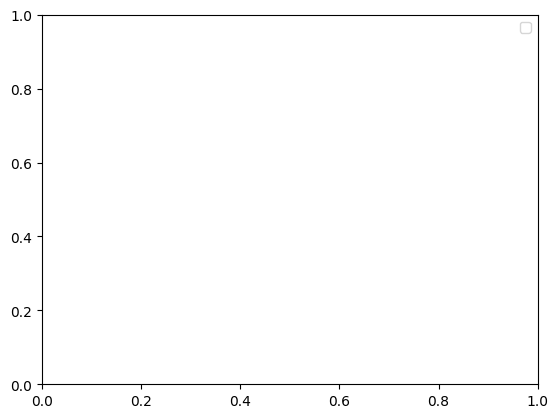

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

chosen_dims = {}
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 5))
# fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 5))
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 5),subplot_kw=dict(projection='3d'))
layer=31
for i,head in enumerate(range(32)):
    layer_mlp_wise_activations = np.squeeze(ah_wise_activations[:,layer,head,:])
    # # layer_mlp_wise_activations = (layer_mlp_wise_activations - layer_mlp_wise_activations.min())/(layer_mlp_wise_activations.max() - layer_mlp_wise_activations.min()) # is it okay to normalise across all dimensions?
    truth_activations = np.vstack([layer_mlp_wise_activations[i,:] for i,label in enumerate(labels) if label==1])
    false_activations = np.vstack([layer_mlp_wise_activations[i,:] for i,label in enumerate(labels) if label==0])
    print(head,'Var:',np.var(truth_activations),np.var(false_activations))
    print(head,'Angle:',angle_between(np.mean(truth_activations,axis=0),np.mean(false_activations,axis=0)))
    act_diff = (np.max(truth_activations,axis=0)-np.max(false_activations,axis=0))/np.max(truth_activations,axis=0)
    counts, bins = np.histogram(act_diff)
    # axes[i].stairs(counts, bins)
    print(len(np.argwhere(act_diff > 0.3)))
    chosen_dims[layer] = np.argwhere(act_diff > 0.3)

    # pca = KernelPCA(n_components=4, kernel='poly') # PCA(n_components=3)
    # transformed = pd.DataFrame(pca.fit_transform(layer_mlp_wise_activations))
    # axes[i,0].scatter(transformed[np.array(labels)==1][0], transformed[np.array(labels)==1][1], label='Okay', c='blue')
    # axes[i,0].scatter(transformed[np.array(labels)==0][0], transformed[np.array(labels)==0][1], label='Hallucinated', c='yellow')
    # axes[i,1].scatter(transformed[np.array(labels)==1][0], transformed[np.array(labels)==1][2], label='Okay', c='blue')
    # axes[i,1].scatter(transformed[np.array(labels)==0][0], transformed[np.array(labels)==0][2], label='Hallucinated', c='yellow')
    # axes[i,2].scatter(transformed[np.array(labels)==1][1], transformed[np.array(labels)==1][2], label='Okay', c='blue')
    # axes[i,2].scatter(transformed[np.array(labels)==0][1], transformed[np.array(labels)==0][2], label='Hallucinated', c='yellow')
    # axes[i,3].scatter(transformed[np.array(labels)==1][3], transformed[np.array(labels)==1][0], label='Okay', c='blue')
    # axes[i,3].scatter(transformed[np.array(labels)==0][3], transformed[np.array(labels)==0][0], label='Hallucinated', c='yellow')
    # axes[i,4].scatter(transformed[np.array(labels)==1][3], transformed[np.array(labels)==1][1], label='Okay', c='blue')
    # axes[i,4].scatter(transformed[np.array(labels)==0][3], transformed[np.array(labels)==0][1], label='Hallucinated', c='yellow')
    # axes[i,5].scatter(transformed[np.array(labels)==1][3], transformed[np.array(labels)==1][2], label='Okay', c='blue')
    # axes[i,5].scatter(transformed[np.array(labels)==0][3], transformed[np.array(labels)==0][2], label='Hallucinated', c='yellow')
    # # # 3d
    # # axes[i].scatter(transformed[labels==1][0], transformed[labels==1][1], transformed[labels==1][2], label='Truthful', c='blue')
    # # axes[i].scatter(transformed[labels==0][0], transformed[labels==0][1], transformed[labels==0][2], label='Non-truthful', c='yellow')
plt.legend()
plt.show()